In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys
from tqdm import tqdm
sys.path.append('/home/drdarby/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
from scipy.interpolate import griddata

In [2]:
path_llc270 = '/media/drdarby/Elements/data/llc270/'

grid_files, grid_filepaths = tools.get_data_paths_from_binary(path_llc270, 'Grid', file_end = 'nc' )
grid = xr.open_mfdataset(grid_filepaths[6])
grid = grid.rename({'i1':'k','i2':'j','i3':'i'})
grid['i'] = (grid['i']-1).astype(int)
grid['j'] = (grid['j']-1).astype(int)
grid['k'] = (grid['k'] -1).astype(int)

In [3]:
grid_filepath = '/media/drdarby/Elements/data/L1_llc1080/L1_N_Greenland_grid.nc'
grid = xr.open_dataset(grid_filepath)#.rename({'XC':'longitude','YC':'latitude'})


In [94]:
grid

<xarray.Dataset>
Dimensions:  (Y: 720, X: 720, Xp1: 721, Yp1: 721, Z: 50)
Coordinates:
    XC       (Y, X) float32 ...
    YC       (Y, X) float32 ...
Dimensions without coordinates: Y, X, Xp1, Yp1, Z
Data variables: (12/14)
    XG       (Y, X) float32 ...
    YG       (Y, X) float32 ...
    AngleCS  (Y, X) float32 ...
    AngleSN  (Y, X) float32 ...
    dxC      (Y, Xp1) float32 ...
    dyC      (Yp1, X) float32 ...
    ...       ...
    HFacC    (Z, Y, X) float32 ...
    HFacW    (Z, Y, Xp1) float32 ...
    HFacS    (Z, Yp1, X) float32 ...
    drF      (Z) float32 ...
    Depth    (Y, X) float32 276.7 276.7 290.6 290.6 290.6 ... 0.0 0.0 0.0 0.0
    rA       (Y, X) float32 ...

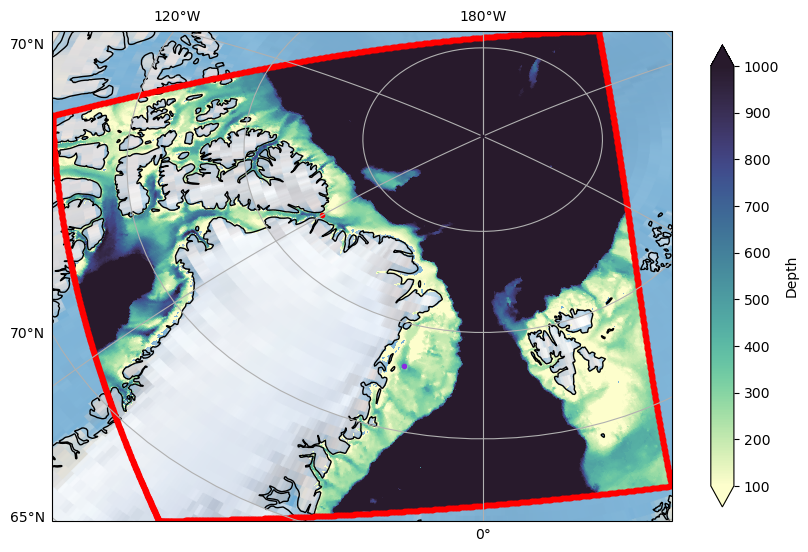

In [7]:
plt.figure(figsize=(10,10))
grid = grid.set_coords({'XC','YC'})
proj = ccrs.Orthographic(central_latitude=50)

ax = plt.axes(projection=proj)

grid.Depth.where(grid.Depth>0).plot(x='XC',y='YC',transform=ccrs.PlateCarree(),ax=ax,cmap=cm.cm.deep,vmin=100,vmax=1000,cbar_kwargs={'shrink':0.6}) #.isel(i=slice(0,150),j=slice(145,270))
plt.plot(grid.Depth.XC[:,0],grid.Depth.YC[:,0],'r.',transform=ccrs.PlateCarree())
plt.plot(grid.Depth.XC[:,-1],grid.Depth.YC[:,-1],'r.',transform=ccrs.PlateCarree())
plt.plot(grid.Depth.XC[0,:],grid.Depth.YC[0,:],'r.',transform=ccrs.PlateCarree())
plt.plot(grid.Depth.XC[-1,:],grid.Depth.YC[-1,:],'r.',transform=ccrs.PlateCarree())

#plt.plot(grid.Depth.XC[0,:],grid.Depth.YC[:,0],'r.',transform=ccrs.PlateCarree())
#plt.plot(grid.Depth.XC[:,0],grid.Depth.YC[0,:],'r.',transform=ccrs.PlateCarree())

ax.coastlines()
ax.stock_img()
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels=False
ax.plot(-16,78,'blueviolet',marker='.',transform=ccrs.PlateCarree())
ax.plot(-60,82.25,'r',marker='.',transform=ccrs.PlateCarree())

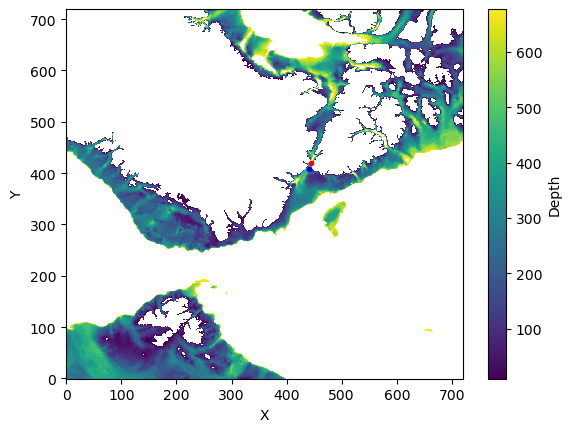

In [208]:
#grid.Depth.sel(Y=slice(300,500),X=slice(400,500)).where(np.logical_and((grid.Depth.sel(Y=slice(300,500),X=slice(400,500))>0),(grid.Depth.sel(Y=slice(300,500),X=slice(400,500))<500))).plot()
grid.Depth.where(np.logical_and((grid.Depth>0),(grid.Depth<700))).plot()

#plt.plot(ind_Nor[0],ind_Nor[1],'r.')
plt.plot(ind_Nar[0],ind_Nar[1],'b.',label='old')
plt.plot(ind_Nar[0]+3,ind_Nar[1]+10,'r.',label='correct')

In [107]:
-16+180


164

In [8]:
llc1080_path = '/media/drdarby/Elements/data/N_Greenland/solution_output/'
llc1080_files, llc1080_filepath = tools.get_data_paths_from_binary(llc1080_path,'llc_1080',file_end='nc')
data_1080 = xr.open_mfdataset(llc1080_filepath).set_coords({'longitude','latitude'})

In [9]:
time = []
for i in range(0,len(llc1080_files)):
    year = llc1080_files[i].split('.')[1][0:4]
    month = llc1080_files[i].split('.')[1][4:6]
    day = 15
    time.append(datetime(int(year),int(month),int(day)))

In [4]:
model_temp_files, model_temp_filepath = tools.get_data_paths_from_binary(path_llc270,'THETA',file_end='nc')
model_temp = xr.open_mfdataset(model_temp_filepath).isel(tile = 6)

In [5]:
data_1080 = data_1080.drop_vars('time')
data_1080 = data_1080.rename({'iterations':'time'})
data_1080.coords['time'] = np.array(time)

NameError: name 'data_1080' is not defined

In [18]:
Theta = data_1080['Theta'][1:]#.rename({'rows':'Y','cols':'X'})

In [19]:
Theta.coords['time'] = np.array(time)

In [13]:
Nordske_lon_lat = (-16,78)
Nares_lon_lat = (-60,82.25)
longitude=np.array(data_1080.isel(time=0).longitude).T
latitude=np.array(data_1080.isel(time=0).latitude).T

abs_lon = np.abs(longitude-Nordske_lon_lat[0])
abs_lat = np.abs(latitude-Nordske_lon_lat[1])
c = np.maximum(abs_lon, abs_lat)
ind_Nor = np.unravel_index(np.argmin(np.array(c), axis=None),c.shape)
abs_lon = np.abs(longitude-Nares_lon_lat[0])
abs_lat = np.abs(latitude-Nares_lon_lat[1])
c = np.maximum(abs_lon, abs_lat)
ind_Nar = np.unravel_index(np.argmin(np.array(c), axis=None),c.shape)
ind_Nor


(192, 330)

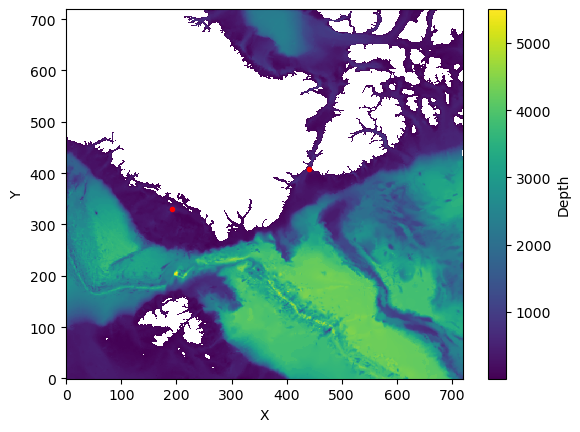

In [14]:
grid.Depth.where(grid.Depth>0).plot()
plt.plot(ind_Nor[0],ind_Nor[1],'r.')
plt.plot(ind_Nar[0],ind_Nar[1],'r.')


In [15]:
data_1080 = data_1080.rename({'rows':'Y','cols':'X'})


In [20]:
Theta

<xarray.DataArray 'Theta' (time: 353, depths: 50, Y: 720, X: 720)>
dask.array<getitem, shape=(353, 50, 720, 720), dtype=float32, chunksize=(2, 50, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-02-15 1992-03-15 ... 2021-12-15
    longitude  (time, Y, X) float32 dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    latitude   (time, Y, X) float32 dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
  * depths     (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: Y, X

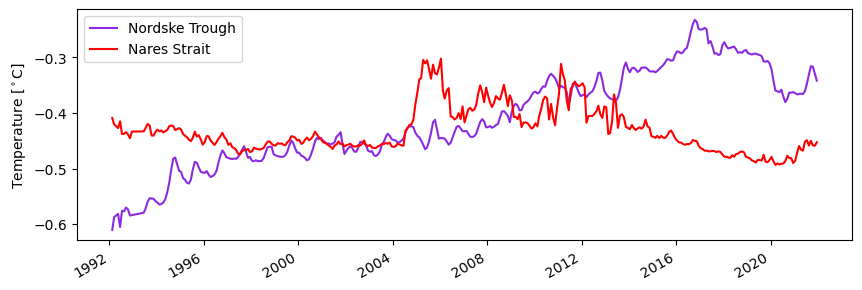

In [21]:
plt.figure(figsize=(10,3))

Theta.sel(X=ind_Nor[0],Y=ind_Nor[1]).mean(dim='depths',skipna=True).plot(color='blueviolet',label='Nordske Trough')
Theta.sel(X=ind_Nar[0]+3,Y=ind_Nar[1]+10).mean(dim='depths',skipna=True).plot(color='r',label='Nares Strait')
plt.ylabel('Temperature [$^\circ$C]')
plt.xlabel('')
plt.legend()

In [ ]:
#(j-90)/4 translating from 1080 to 270




PETERMANN_GLETSCHER
STEENSBY_GLETSCHER
RYDER_GLETSCHER


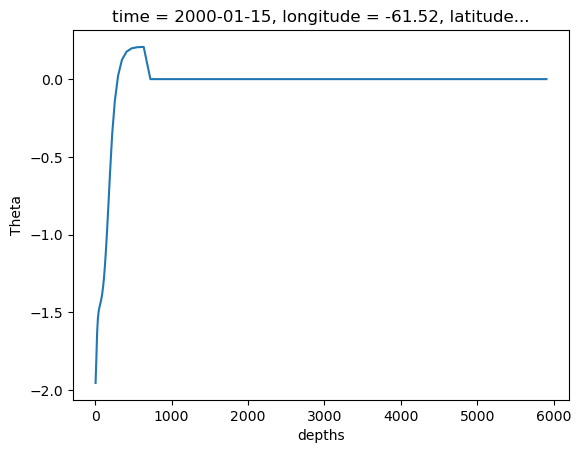

In [189]:
data_1080['Theta'].isel(time=0).sel(X=ind_Nar[0]+3,Y=ind_Nar[1]+10).plot()


/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


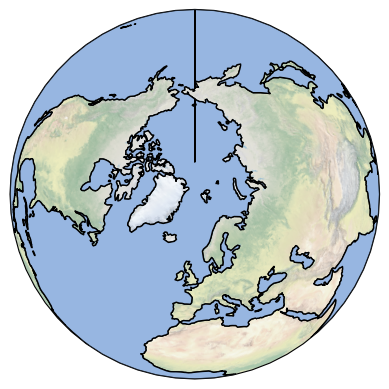

In [44]:
proj = ccrs.Orthographic(central_latitude=80)

ax = plt.axes(projection=proj)
ax.coastlines()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.stock_img()
plt.show()

Text(0.5, 1.0, 'whole water column')

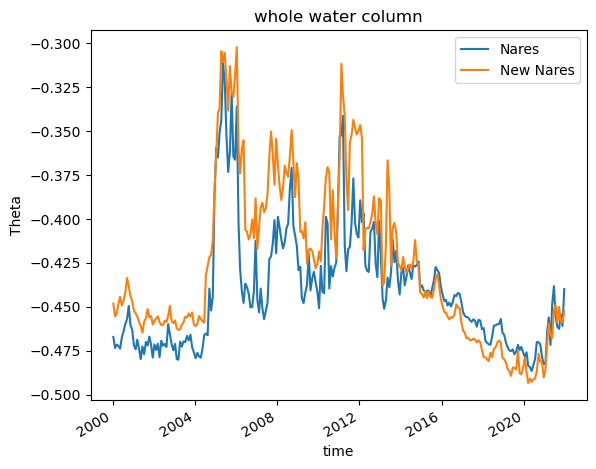

In [195]:
data_1080['Theta'].sel(X=ind_Nar[0],Y=ind_Nar[1]).mean(dim='depths',skipna=True).plot(label='Nares')
data_1080['Theta'].sel(X=ind_Nar[0]+3,Y=ind_Nar[1]+10).mean(dim='depths',skipna=True).plot(label='New Nares')
plt.legend()
plt.title('whole water column')

Text(0.5, 1.0, 'deeper than 200m')

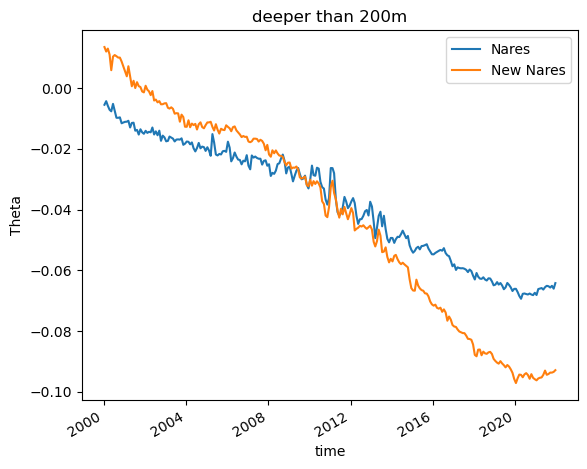

In [193]:
data_1080['Theta'].sel(X=ind_Nar[0],Y=ind_Nar[1]).where(data_1080.depths>200).mean(dim='depths',skipna=True).plot(label='Nares')
data_1080['Theta'].sel(X=ind_Nar[0]+3,Y=ind_Nar[1]+10).where(data_1080.depths>200).mean(dim='depths',skipna=True).plot(label='New Nares')
plt.legend()
plt.title('deeper than 200m')

In [194]:
np.array(data_1080.depths)

array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5005005e+01,
       8.5025002e+01, 9.5095001e+01, 1.0531000e+02, 1.1587000e+02,
       1.2715000e+02, 1.3973999e+02, 1.5447000e+02, 1.7239999e+02,
       1.9473500e+02, 2.2271001e+02, 2.5747000e+02, 2.9992999e+02,
       3.5067999e+02, 4.0992999e+02, 4.7747000e+02, 5.5271002e+02,
       6.3473505e+02, 7.2240002e+02, 8.1447009e+02, 9.0974011e+02,
       1.0071550e+03, 1.1059050e+03, 1.2055350e+03, 1.3062051e+03,
       1.4091499e+03, 1.5170950e+03, 1.6341748e+03, 1.7651348e+03,
       1.9141499e+03, 2.0840349e+03, 2.2762251e+03, 2.4912500e+03,
       2.7292500e+03, 2.9902500e+03, 3.2742500e+03, 3.5812500e+03,
       3.9112500e+03, 4.2642500e+03, 4.6402500e+03, 5.0392500e+03,
       5.4612500e+03, 5.9062500e+03], dtype=float32)

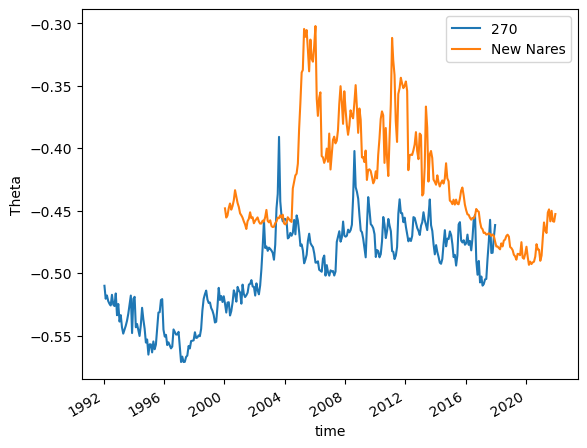

In [233]:
model_temp['THETA'].isel(i=int(ind_Nar[0]/4)+1,j=int(ind_Nar[1]/2-12)+1).mean(dim='k',skipna=True).plot(label='270')
data_1080['Theta'].sel(X=ind_Nar[0]+3,Y=ind_Nar[1]+10).mean(dim='depths',skipna=True).plot(label='New Nares')
plt.legend()
#plt.plot(ind_Nar[0]/4,ind_Nar[1]/2-12,'r.')

(100.0, 125.0)

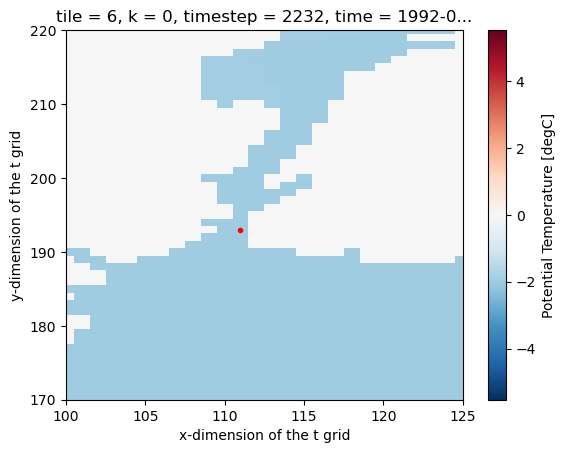

In [231]:
model_temp['THETA'].isel(k=0,time=0).plot()
plt.plot(int(ind_Nar[0]/4)+1,int(ind_Nar[1]/2-12)+1,'r.')
plt.ylim(170,220)
plt.xlim(100,125)